In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import keras_tuner as kt

from sklearn.metrics import mean_absolute_error, mean_squared_error


tf.__version__

2023-04-03 10:10:19.567330: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-03 10:10:19.655991: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-03 10:10:20.063451: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-04-03 10:10:20.063501: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

'2.11.0'

In [2]:
# Load dataset
csv_file = '../Dataset/dataset_left.csv'
dataframe_raw = pd.read_csv(csv_file)
dataframe_raw = dataframe_raw.drop(dataframe_raw.columns[0],axis=1) # remove first column (no information there)
dataframe_raw.head()

,Pos1,Pos2,Pos3,Pos4,Pos5,Pos6,Pos7,Pos8,Pos9,Pos10,Pos11,Pos12,Pos13,Pos14,Pos15,Pos16,Nsubs,R,lambd
0,0,0,0,0,0,4,1,0,0,0,0,0,0,0,0,0,2,484.4822,350.23
1,0,4,2,0,0,0,0,0,0,0,0,0,0,0,0,0,2,774.6917,347.50
2,3,3,0,0,0,0,0,1,2,0,0,0,0,0,0,0,4,644.6140,364.11
3,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,630.3364,347.10
4,0,1,0,0,4,0,0,0,0,4,0,3,0,0,0,0,4,392.8587,358.78


In [3]:
dataframe = dataframe_raw.copy()

# Create a target variable
dataframe['target'] = dataframe['R']

# Create array with number of subtitutes
nsubs = []
nsubs[:] = dataframe['Nsubs']

# Drop unused features.
dataframe = dataframe.drop(columns=['R', 'lambd', 'Nsubs'])
dataframe.head()

,Pos1,Pos2,Pos3,Pos4,Pos5,Pos6,Pos7,Pos8,Pos9,Pos10,Pos11,Pos12,Pos13,Pos14,Pos15,Pos16,target
0,0,0,0,0,0,4,1,0,0,0,0,0,0,0,0,0,484.4822
1,0,4,2,0,0,0,0,0,0,0,0,0,0,0,0,0,774.6917
2,3,3,0,0,0,0,0,1,2,0,0,0,0,0,0,0,644.6140
3,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,630.3364
4,0,1,0,0,4,0,0,0,0,4,0,3,0,0,0,0,392.8587


1
32
140
40
40


(array([  1.,  32., 140.,  40.,  40.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5]),
 <BarContainer object of 5 artists>)

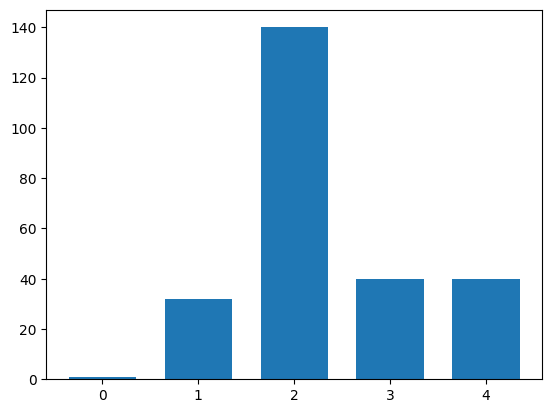

In [4]:
# number of substitutes

n0 = nsubs.count(0)
n1 = nsubs.count(1)
n2 = nsubs.count(2)
n3 = nsubs.count(3)
n4 = nsubs.count(4)
print(n0)
print(n1)
print(n2)
print(n3)
print(n4)

bin_edges = np.arange(-0.5,4.5+1,1)
plt.hist(nsubs, bins=bin_edges, rwidth=0.7)

In [5]:
# Check overal statistis of each input feature 
dataframe.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Pos1,253.0,0.664032,1.251099,0.0000,0.0000,0.0000,1.0000,4.0000
Pos2,253.0,0.774704,1.388956,0.0000,0.0000,0.0000,1.0000,4.0000
Pos3,253.0,0.632411,1.258013,0.0000,0.0000,0.0000,0.0000,4.0000
Pos4,253.0,0.557312,1.218930,0.0000,0.0000,0.0000,0.0000,4.0000
Pos5,253.0,0.513834,1.121934,0.0000,0.0000,0.0000,0.0000,4.0000
Pos6,253.0,0.430830,1.054167,0.0000,0.0000,0.0000,0.0000,4.0000
Pos7,253.0,0.383399,1.007532,0.0000,0.0000,0.0000,0.0000,4.0000
Pos8,253.0,0.533597,1.163200,0.0000,0.0000,0.0000,0.0000,4.0000
Pos9,253.0,0.332016,0.904378,0.0000,0.0000,0.0000,0.0000,4.0000
Pos10,253.0,0.284585,0.867193,0.0000,0.0000,0.0000,0.0000,4.0000


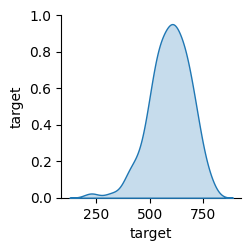

In [6]:
# Inspect the data with the joint distribition of a few pairs of columns from the training set
sns.pairplot(dataframe[['target']], diag_kind='kde')


In [7]:
# remove data with R~8

dataframe = dataframe[ dataframe['target']>10 ]
dataframe.describe().transpose()

# remove data with target<Rmin
Rmin = 380
dataframe = dataframe[ dataframe['target']>Rmin ]
print(dataframe.describe().transpose())

        count        mean        std       min      25%       50%       75%  \
Pos1    249.0    0.646586   1.239308    0.0000    0.000    0.0000    1.0000   
Pos2    249.0    0.738956   1.353061    0.0000    0.000    0.0000    1.0000   
Pos3    249.0    0.614458   1.239452    0.0000    0.000    0.0000    0.0000   
Pos4    249.0    0.534137   1.187909    0.0000    0.000    0.0000    0.0000   
Pos5    249.0    0.510040   1.118439    0.0000    0.000    0.0000    0.0000   
Pos6    249.0    0.437751   1.061202    0.0000    0.000    0.0000    0.0000   
Pos7    249.0    0.389558   1.014438    0.0000    0.000    0.0000    0.0000   
Pos8    249.0    0.542169   1.170551    0.0000    0.000    0.0000    0.0000   
Pos9    249.0    0.337349   0.910651    0.0000    0.000    0.0000    0.0000   
Pos10   249.0    0.289157   0.873399    0.0000    0.000    0.0000    0.0000   
Pos11   249.0    0.212851   0.739766    0.0000    0.000    0.0000    0.0000   
Pos12   249.0    0.248996   0.834156    0.0000    0.

In [8]:
# normalize numerical targets

R_mean = dataframe['target'].mean()
R_std = dataframe['target'].std()

dataset = dataframe.copy()

dataset['target']=(dataset['target']-R_mean)/R_std

# Check overal statistis of each input feature 
dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Pos1,249.0,6.465863e-01,1.239308,0.000000,0.000000,0.000000,1.000000,4.000000
Pos2,249.0,7.389558e-01,1.353061,0.000000,0.000000,0.000000,1.000000,4.000000
Pos3,249.0,6.144578e-01,1.239452,0.000000,0.000000,0.000000,0.000000,4.000000
Pos4,249.0,5.341365e-01,1.187909,0.000000,0.000000,0.000000,0.000000,4.000000
Pos5,249.0,5.100402e-01,1.118439,0.000000,0.000000,0.000000,0.000000,4.000000
Pos6,249.0,4.377510e-01,1.061202,0.000000,0.000000,0.000000,0.000000,4.000000
Pos7,249.0,3.895582e-01,1.014438,0.000000,0.000000,0.000000,0.000000,4.000000
Pos8,249.0,5.421687e-01,1.170551,0.000000,0.000000,0.000000,0.000000,4.000000
Pos9,249.0,3.373494e-01,0.910651,0.000000,0.000000,0.000000,0.000000,4.000000
Pos10,249.0,2.891566e-01,0.873399,0.000000,0.000000,0.000000,0.000000,4.000000


In [9]:
# Shuffle the dataset
dataset = dataset.sample(frac=1,random_state=39).reset_index(drop=True)

# Split the dataframe into training, validation, and test sets

### IMPORTANT: Select for normalization
#train, val, test = np.split(dataframe.sample(frac=1), [int(0.8*len(dataframe)), int(0.9*len(dataframe))])
train, val, test = np.split(dataset.sample(frac=1), [int(0.8*len(dataset)), int(0.9*len(dataset))])
print(len(train), 'training examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

199 training examples
25 validation examples
25 test examples


In [10]:
# Create an input pipeline using tf.data

def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  df = dataframe.copy()
  labels = df.pop('target')
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

# Example: 
batch_size = 1
train_ds = df_to_dataset(train, batch_size=batch_size)

[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of Pos1:', train_features['Pos1'])
print('A batch of targets (R):', label_batch )

Every feature: ['Pos1', 'Pos2', 'Pos3', 'Pos4', 'Pos5', 'Pos6', 'Pos7', 'Pos8', 'Pos9', 'Pos10', 'Pos11', 'Pos12', 'Pos13', 'Pos14', 'Pos15', 'Pos16', 'target']
A batch of Pos1: tf.Tensor([[3]], shape=(1, 1), dtype=int64)
A batch of targets (R): tf.Tensor([-1.89092977], shape=(1,), dtype=float64)


/tmp/ipykernel_45749/3198051929.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
2023-04-03 10:10:41.637617: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-03 10:10:41.659671: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-04-03 10:10:41.659692: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guid

In [11]:
# Numerical columns preprocessing layer

def get_normalization_layer(name, dataset):
  # Create a Normalization layer for the feature.
  normalizer = layers.Normalization(axis=None)

  # Prepare a Dataset that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

In [12]:
# Categorical columns preprocessing layer

def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a layer that turns strings into integer indices.
  if dtype == 'string':
    index = layers.StringLookup(_tokens=max_tokens)
  # Otherwise, create a layer that turns integer values into integer indices.
  else:
    index = layers.IntegerLookup(max_tokens=max_tokens)

  # Prepare a `tf.data.Dataset` that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Encode the integer indices.
  encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply multi-hot encoding to the indices. The lambda function captures the
  # layer, so you can use them, or include them in the Keras Functional model later.
  return lambda feature: encoder(index(feature))

In [13]:
# Create an input pipeline
batch_size = 2
# shuffle is set to False, as it was already done before
#train_ds = df_to_dataset(train, batch_size=batch_size)
train_ds = df_to_dataset(train, shuffle=False, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

/tmp/ipykernel_45749/3198051929.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
/tmp/ipykernel_45749/3198051929.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}


In [14]:
# Preprocess selected features (categorical and numerical)

all_inputs = []
encoded_features = []

# Multi-hot encoding and add the resulting feature inputs to encoded_features
categorical_cols = ['Pos1', 'Pos2', 'Pos3', 'Pos4', 'Pos5', 'Pos6', 
                    'Pos7', 'Pos8', 'Pos9', 'Pos10', 'Pos11', 'Pos12', 
                    'Pos13', 'Pos14', 'Pos15', 'Pos16']
#categorical_cols= list(train_features.keys())
#categorical_cols = categorical_cols[0:16]
print("Categorical cols: "+str(categorical_cols))
for header in categorical_cols:
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='int64')
  encoding_layer = get_category_encoding_layer(name=header,
                                               dataset=train_ds,
                                               dtype='int64',
                                               max_tokens=5)
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)

# Normalize numerical features.
""" numeric_cols = ['X', 'Y', 'Z']
print("Numerical cols: "+str(numeric_cols))
for header in numeric_cols:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col) """

""" numeric_cols = ['target']
print("Numerical cols: "+str(numeric_cols))
for header in numeric_cols:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col) """

Categorical cols: ['Pos1', 'Pos2', 'Pos3', 'Pos4', 'Pos5', 'Pos6', 'Pos7', 'Pos8', 'Pos9', 'Pos10', 'Pos11', 'Pos12', 'Pos13', 'Pos14', 'Pos15', 'Pos16']
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


' numeric_cols = [\'target\']\nprint("Numerical cols: "+str(numeric_cols))\nfor header in numeric_cols:\n  numeric_col = tf.keras.Input(shape=(1,), name=header)\n  normalization_layer = get_normalization_layer(header, train_ds)\n  encoded_numeric_col = normalization_layer(numeric_col)\n  all_inputs.append(numeric_col)\n  encoded_features.append(encoded_numeric_col) '

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Pos1 (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 Pos2 (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 Pos3 (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 Pos4 (InputLayer)              [(None, 1)]          0           []                               
                                                                                            

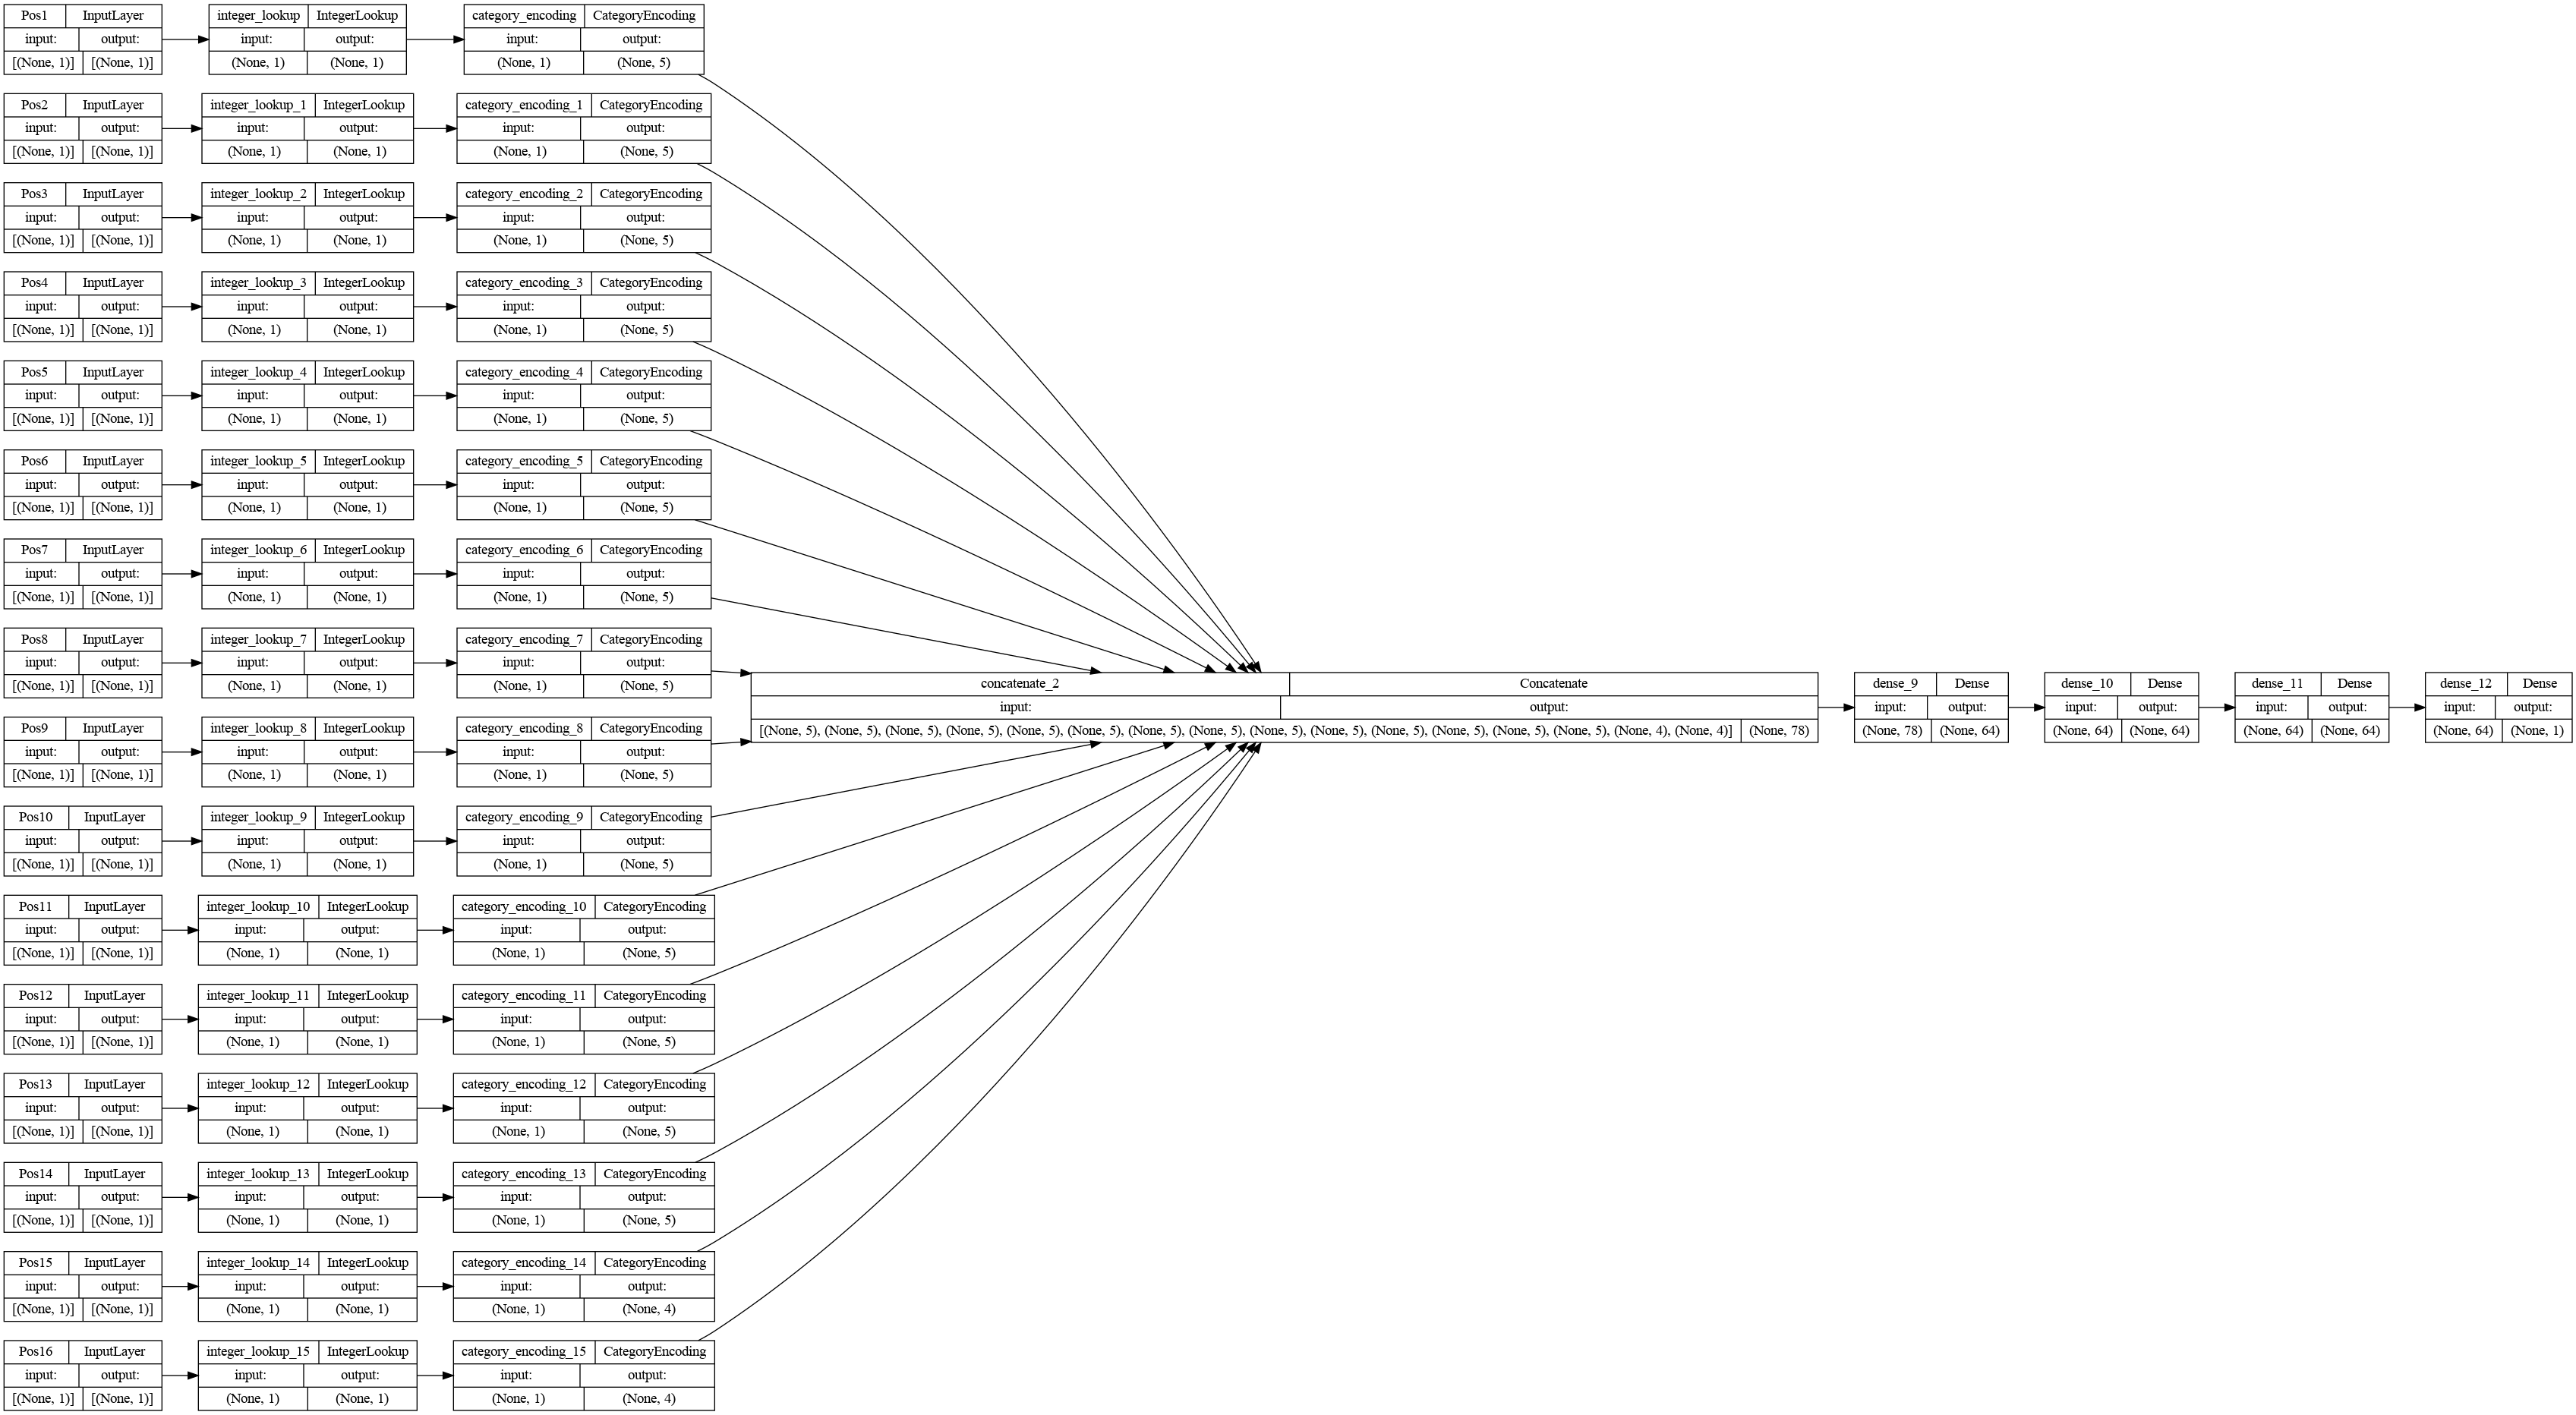

In [24]:
# Create the model architecture
all_features = tf.keras.layers.concatenate(encoded_features)

# tiny model
#x = tf.keras.layers.Dense(8, activation="relu")(all_features)

# small model 
#x = tf.keras.layers.Dense(16, activation="relu")(all_features)
#x = tf.keras.layers.Dense(16, activation="relu")(x)

# medium model
x = tf.keras.layers.Dense(64, activation="relu")(all_features)
x = tf.keras.layers.Dense(64, activation="relu")(x)
x = tf.keras.layers.Dense(64, activation="relu")(x)

# large model
#x = tf.keras.layers.Dense(512, activation="relu")(all_features)
#x = tf.keras.layers.Dense(512, activation="relu")(x)
#x = tf.keras.layers.Dense(512, activation="relu")(x)
#x = tf.keras.layers.Dense(512, activation="relu")(x)

# large model with L2-regularization and dropout
""" x = tf.keras.layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001), activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001), activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001), activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001), activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x) """

#x = tf.keras.layers.Dense(10)(x)
output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(all_inputs, output)
model.summary()

#loss='mean_absolute_error',optimizer=tf.keras.optimizers.Adam(0.001)
# compile the model
model.compile(#optimizer='adam',
              #loss='mean_absolute_error',
              #loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              loss=tf.keras.losses.MeanAbsoluteError(),
              optimizer=tf.keras.optimizers.Adam(0.0001)
              #optimizer=tf.keras.optimizers.Adam(0.001),
              #metrics=["accuracy"])
)

tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")


In [25]:
# Train the model
history = model.fit(train_ds, epochs=200, verbose=2, validation_data=val_ds)


Epoch 1/200


/home/alfonso/Work/UGR/Calculations/Helicenes_GNNs/Helicenes_venv/lib/python3.10/site-packages/keras/engine/functional.py:638: UserWarning: Input dict contained keys ['target'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


100/100 - 1s - loss: 0.7634 - val_loss: 0.8458 - 1s/epoch - 11ms/step
Epoch 2/200
100/100 - 0s - loss: 0.7414 - val_loss: 0.8609 - 98ms/epoch - 979us/step
Epoch 3/200
100/100 - 0s - loss: 0.7254 - val_loss: 0.8514 - 97ms/epoch - 969us/step
Epoch 4/200
100/100 - 0s - loss: 0.7092 - val_loss: 0.8363 - 97ms/epoch - 972us/step
Epoch 5/200
100/100 - 0s - loss: 0.6895 - val_loss: 0.8163 - 98ms/epoch - 977us/step
Epoch 6/200
100/100 - 0s - loss: 0.6628 - val_loss: 0.7955 - 98ms/epoch - 975us/step
Epoch 7/200
100/100 - 0s - loss: 0.6333 - val_loss: 0.7652 - 97ms/epoch - 967us/step
Epoch 8/200
100/100 - 0s - loss: 0.6007 - val_loss: 0.7244 - 97ms/epoch - 968us/step
Epoch 9/200
100/100 - 0s - loss: 0.5647 - val_loss: 0.6819 - 97ms/epoch - 966us/step
Epoch 10/200
100/100 - 0s - loss: 0.5285 - val_loss: 0.6511 - 97ms/epoch - 971us/step
Epoch 11/200
100/100 - 0s - loss: 0.4862 - val_loss: 0.6071 - 99ms/epoch - 987us/step
Epoch 12/200
100/100 - 0s - loss: 0.4520 - val_loss: 0.5912 - 99ms/epoch - 990

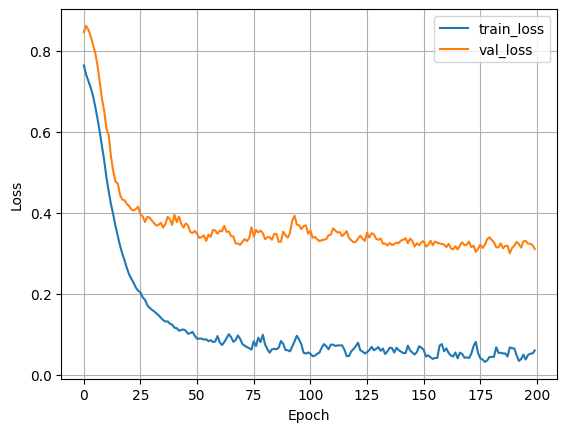

In [26]:
# Plot the loss

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
#plt.ylim([0, 10])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

In [27]:
def plot_PredvsTrue(y_true, y_pred):

    plt.figure(figsize=(3, 3), dpi=200)
    p1 = min(y_true)
    p2 = max(y_true)
    #p1 = 0
    #p2 = 64
    #p1 = max(max(y_pred), max(y_true))
    #p2 = min(min(y_pred), min(y_true))
    plt.plot([p1, p2], [p1, p2], 'r--', label="Exact")
    plt.scatter(y_true,y_pred,color="blue",label="Model",s=6)
    plt.xlabel('True',fontsize=15)
    plt.ylabel('Pred',fontsize=15)
    plt.legend(loc="upper left")
    plt.show()

13/13 [==============================] - 0s 971us/step
(25, 1)
(25, 1)


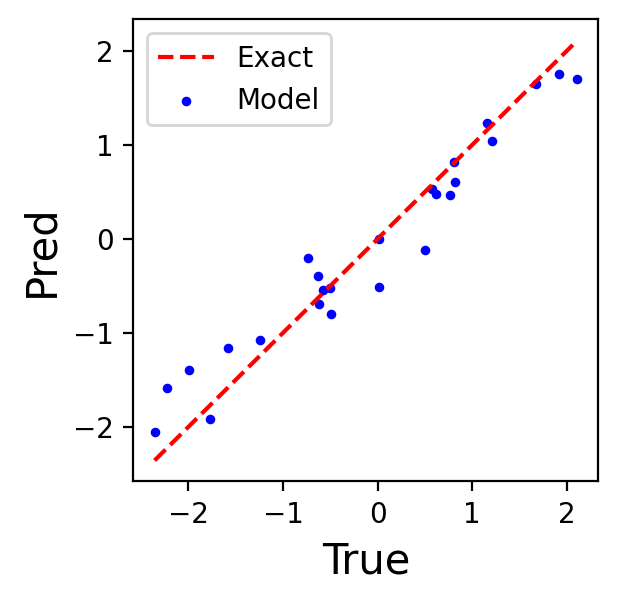

Test MAE: 0.24717235987087943


In [28]:
# Pred vs True values on test set 

y_pred = model.predict(test_ds)
y_pred.shape
y_true = np.zeros((len(test['target']),1))
y_true[:,0] = test['target']

print(y_true.shape)
print(y_pred.shape)
#print(y_true)
#print(y_pred)

plot_PredvsTrue(y_true, y_pred)

test_mae = mean_absolute_error(y_true,y_pred)
print("Test MAE: "+str(test_mae))

100/100 [==============================] - 0s 851us/step
(199, 1)
(199, 1)


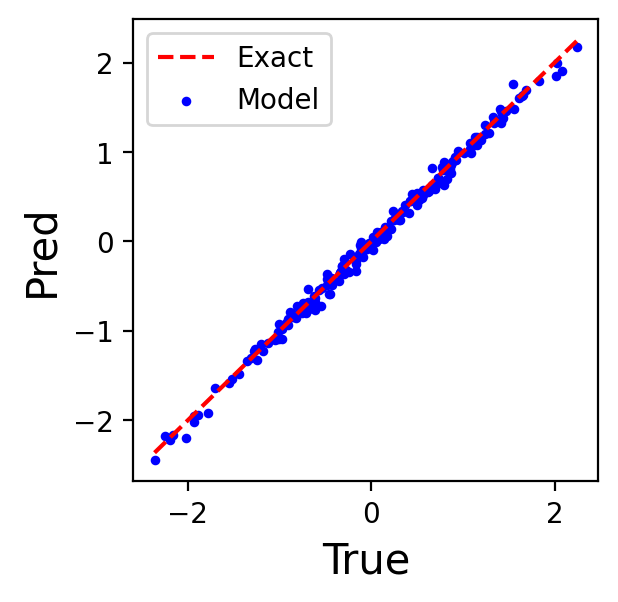

Train MAE: 0.051942218292220135


In [29]:
# Pred vs True values on training set 

y_pred = model.predict(train_ds)
y_pred.shape
y_true = np.zeros((len(train['target']),1))
y_true[:,0] = train['target']

print(y_true.shape)
print(y_pred.shape)
#print(y_true)
#print(y_pred)

plot_PredvsTrue(y_true, y_pred)

test_mae = mean_absolute_error(y_true,y_pred)
print("Train MAE: "+str(test_mae))

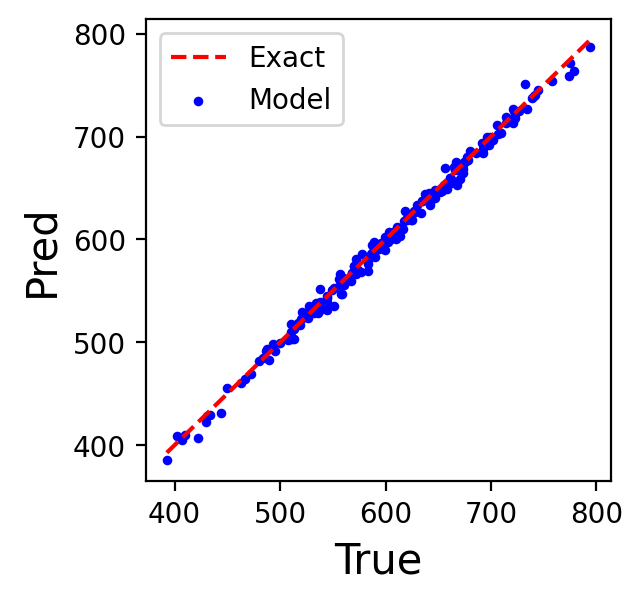

Train MAE (non-normalized): 4.519164535568469


In [30]:
# Evaluate the model with non-normalized units

y_true = y_true * R_std + R_mean
y_pred = y_pred * R_std + R_mean

#print("True: "+str(y_true))
#print("Pred: "+str(y_pred))

plot_PredvsTrue(y_true, y_pred)

test_mae = mean_absolute_error(y_true,y_pred)
print("Train MAE (non-normalized): "+str(test_mae))

In [139]:
# save model

#model.save('R_model_good_tiny')
#model.save('R_model_good_small')
#model.save('R_model_good_medium')
#model.save('R_model_good_large')
#reloaded_model = tf.keras.models.load_model('R_model')

13/13 [==============================] - 0s 869us/step


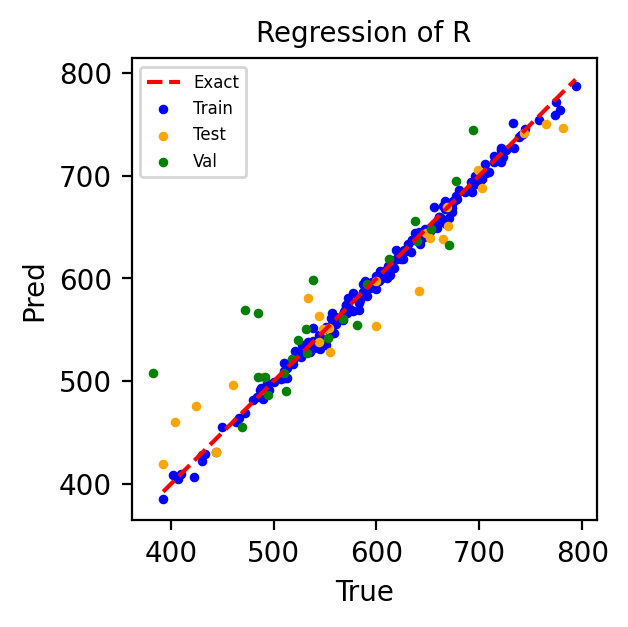

train MAE (non-normalized): 4.519164535568469
test MAE (non-normalized): 21.504929103515625
val MAE (non-normalized): 27.005772669921885


In [31]:
# Evaluate the model with non-normalized units on the whole dataset

y_pred_test = model.predict(test_ds)
y_true_test = np.zeros((len(test['target']),1))
y_true_test[:,0] = test['target']

y_pred_train = model.predict(train_ds)
y_true_train = np.zeros((len(train['target']),1))
y_true_train[:,0] = train['target']

y_pred_val = model.predict(val_ds)
y_true_val = np.zeros((len(val['target']),1))
y_true_val[:,0] = val['target']

y_true_test = y_true_test * R_std + R_mean
y_pred_test = y_pred_test * R_std + R_mean
y_true_test = y_true_test.ravel()
y_pred_test = y_pred_test.ravel()

y_true_train = y_true_train * R_std + R_mean
y_pred_train = y_pred_train * R_std + R_mean
y_true_train = y_true_train.ravel()
y_pred_train = y_pred_train.ravel()

y_true_val = y_true_val * R_std + R_mean
y_pred_val = y_pred_val * R_std + R_mean
y_true_val = y_true_val.ravel()
y_pred_val = y_pred_val.ravel()

plt.figure(figsize=(3, 3), dpi=200)
plt.title("Regression of R",fontsize=10)
p1 = min(y_true_train)
p2 = max(y_true_train)
plt.plot([p1, p2], [p1, p2], 'r--', label="Exact")
plt.scatter(y_true_train,y_pred_train,color="blue",label="Train",s=6)
plt.scatter(y_true_test,y_pred_test,color="orange",label="Test",s=6)
plt.scatter(y_true_val,y_pred_val,color="green",label="Val",s=6)
plt.xlabel('True',fontsize=10)
plt.ylabel('Pred',fontsize=10)
plt.legend(loc="upper left",prop={'size': 6})
plt.show()

train_mae = mean_absolute_error(y_true_train,y_pred_train)
print("train MAE (non-normalized): "+str(train_mae))
test_mae = mean_absolute_error(y_true_test,y_pred_test)
print("test MAE (non-normalized): "+str(test_mae))
val_mae = mean_absolute_error(y_true_val,y_pred_val)
print("val MAE (non-normalized): "+str(val_mae))

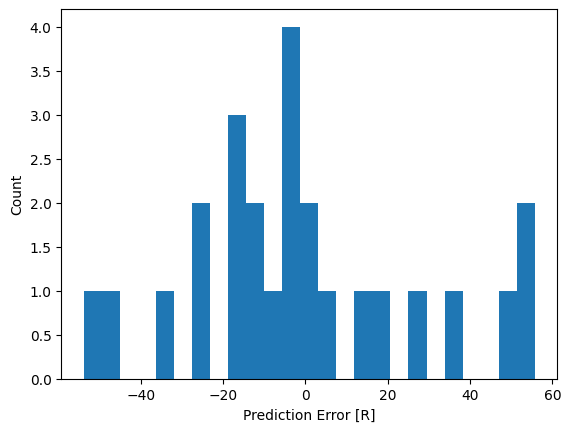

In [32]:
# Error distribution
error = y_pred_test - y_true_test
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [R]')
_ = plt.ylabel('Count')
